출처 \
https://www.kaggle.com/code/aharless/xgboost-cv-lb-284/notebook \
https://kubig-2021-2.tistory.com/38

In [ ]:
MAX_ROUNDS = 400
OPTIMIZE_ROUNDS = False
LEARNING_RATE = 0.07
EARLY_STOPPING_ROUNDS = 10
# EARLY_STOPPING_ROUNDS를 매우 높게 설정하였습니다.(50, OPTIMIZE_ROUNDS가 설정되어 있을 때)
# 실제로 early stopping을 사용하고 싶다면 EARLY_STOPPING_ROUNDS를 줄여주세요

rounds의 적절한 수에 대한 아이디어를 얻기 위해 초기에 MAX_ROUNDS를 매우 높게 설정하고 OPTIMIZE_ROUNDS를 사용하는 것을 추천합니다. (모든 fold 중에서 $best\_ntree\_limit$의 최댓값에 가까워야하며 모델이 적절하게 정규화되었다면 조금 더 높을 수 있습니다. 아니면 $verbose=True$로 설정하여 디테일을 살펴본 후 모든 fold에 잘 작동되는 round를 찾습니다). 그 후, OPTIMIZEZ_ROUNDS를 끄고, 최적의 MAX_ROUNDS의 값을 설정합니다.

각 fold에서 가장 적합한 round를 설정해 early stopping하는 가장 큰 문제점은 validation data에 overfitting된다는 것입니다. 그러므로 test data를 예측하는데 최적의 모델을 만들지 못할 가능성이 있고, 만약 다른 모델과의 stacking/ensembling을 위한 validation data를 생성하는데 사용된다면 이 모델이 앙상블에 너무 많은 weight을 갖게 됩니다. 또 다른 가능성(XGBoost의 default)은 최적의 round보다 early stopping이 일어났을때의 round를 사용한다는 것입니다.

early stopping이 overfitting 문제는 해결하지만, 20-round early stopping에서 일정한 값의 round보다 validation score가 낮게 나온 것을 봤을때, early stopping은 약간 underfitting된 것처럼 보입니다.



In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc

In [ ]:
# Compute gini

@jit # 넘파이 코드를 빠르게 실행시켜주는 JIT 컴파일러
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true) # numba가 이해할 수 있는 형식으로 변환
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

In [ ]:
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    # 해당 커널에서 분류에 사용한 XGBClassifier모델은 평가 지표로 rmse와 같은 값을 사용 -> 즉 오류의 최솟값을 찾음
    # 이 대회의 평가 지표인 지니 계수 : 0.5에 가까울수록(값이 클수록) 좋은 값이기 때문에 -를 붙여주는 함수를 생성
    return [("gini", gini_score)]

**범주형 변수 인코딩**

해당 커널에서는 distinct value가 많은 ps_car_11_cat 변수들에 대해서는 mean encoding을 사용하였고, 나머지 범주형 변수들에 대해서는 더미 변수를 생성하는 one-hot encoding의 방식 사용

 

**Mean encoding이란?**

<목표>

카테고리 변수에 대하여 (여기서는 104개의 카테고리를 가진 ps_car_11_cat 변수에 대하여) 단순하게 0,1로 구분된 target값에 대한 의미를 가지도록 만드는 것

 

<Method>

카테고리 변수의 Label 값에 따라서 Target 값의 평균을 구해 각 Label이 Target과 가지는 상관성, 영향 도출

 

<문제점>

 

1. target값을 이용해 계산하기 때문에 overfitting의 문제가 발생할 수 있음 -> 이 커널에서는 noise를 추가하는 방식으로 이 문제를 해결

 

2. test 데이터와 train 데이터 간의 분포가 다른 경우 (ex. 한쪽이 불균형 데이터인 경우) 이때도 마찬가지로 overfitting의 문제 발생 가능 -> Smoothing을 통해 문제 해결

 

Smoothing 공식
    
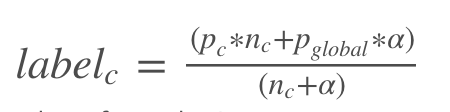

In [ ]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    '''
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int): category 평균을 고려하기 위한 최소 샘플 수
    smoothing (int): categorical average와 prior의 균형을 맞추기 위한 smoothing effect
    '''
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [ ]:
train_df = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv', na_values="-1")
test_df = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv', na_values="-1")

In [ ]:
# from olivier
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
    "ps_reg_03",  #            : 1408.42 / shadow  511.15
    "ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
    "ps_ind_03",  #            : 1219.47 / shadow  230.55
    "ps_ind_15",  #            :  922.18 / shadow  242.00
    "ps_reg_02",  #            :  920.65 / shadow  267.50
    "ps_car_14",  #            :  798.48 / shadow  549.58
    "ps_car_12",  #            :  731.93 / shadow  293.62
    "ps_car_01_cat",  #        :  698.07 / shadow  178.72
    "ps_car_07_cat",  #        :  694.53 / shadow   36.35
    "ps_ind_17_bin",  #        :  620.77 / shadow   23.15
    "ps_car_03_cat",  #        :  611.73 / shadow   50.67
    "ps_reg_01",  #            :  598.60 / shadow  178.57
    "ps_car_15",  #            :  593.35 / shadow  226.43
    "ps_ind_01",  #            :  547.32 / shadow  154.58
    "ps_ind_16_bin",  #        :  475.37 / shadow   34.17
    "ps_ind_07_bin",  #        :  435.28 / shadow   28.92
    "ps_car_06_cat",  #        :  398.02 / shadow  212.43
    "ps_car_04_cat",  #        :  376.87 / shadow   76.98
    "ps_ind_06_bin",  #        :  370.97 / shadow   36.13
    "ps_car_09_cat",  #        :  214.12 / shadow   81.38
    "ps_car_02_cat",  #        :  203.03 / shadow   26.67
    "ps_ind_02_cat",  #        :  189.47 / shadow   65.68
    "ps_car_11",  #            :  173.28 / shadow   76.45
    "ps_car_05_cat",  #        :  172.75 / shadow   62.92
    "ps_calc_09",  #           :  169.13 / shadow  129.72
    "ps_calc_05",  #           :  148.83 / shadow  120.68
    "ps_ind_08_bin",  #        :  140.73 / shadow   27.63
    "ps_car_08_cat",  #        :  120.87 / shadow   28.82
    "ps_ind_09_bin",  #        :  113.92 / shadow   27.05
    "ps_ind_04_cat",  #        :  107.27 / shadow   37.43
    "ps_ind_18_bin",  #        :   77.42 / shadow   25.97
    "ps_ind_12_bin",  #        :   39.67 / shadow   15.52
    "ps_ind_14",  #            :   37.37 / shadow   16.65
]

# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]

In [ ]:
# Process data
id_test = test_df['id'].values
id_train = train_df['id'].values
y = train_df['target']

start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f'
          % (name1, n_c + 1, (time.time() - start) / 60))
    
    train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
    test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
    
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
    train_df[name1] = lbl.transform(list(train_df[name1].values))
    test_df[name1] = lbl.transform(list(test_df[name1].values))

    train_features.append(name1)
    
X = train_df[train_features]
test_df = test_df[train_features]

f_cats = [f for f in X.columns if "_cat" in f]

In [ ]:
y_valid_pred = 0 * y
y_test_pred = 0

In [ ]:
# Set up folds
K = 5
kf = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
np.random.seed(0)

In [ ]:
# Set up classifier
model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [ ]:
# Run CV

for i, (train_index, test_index) in enumerate(kf.split(train_df, train_df["target"])):
    
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)
    
    # Enocode data
    for f in f_cats:
        X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        val_series=X_valid[f],
                                                        tst_series=X_test[f],
                                                        target=y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        eval_set=[(X_valid,y_valid)]
        fit_model = model.fit( X_train, y_train, 
                               eval_set=eval_set,
                               eval_metric=gini_xgb,
                               early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                               verbose=False
                             )
        print( "  Best N trees = ", model.best_ntree_limit )
        print( "  Best gini = ", model.best_score )
    else:
        fit_model = model.fit( X_train, y_train )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    # predict_proba의 출력은 각 클래스에 대한 확률, 이진 분류에서는 항상 사이즈가 (n_samples, 2)
    print("  Gini = ", eval_gini(y_valid, pred))
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:, 1]
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K

print( "\nGini for full training set:" )
eval_gini(y, y_valid_pred)

In [ ]:
# Save validation predictions for stacking/ensembling
val = pd.DataFrame()
val['id'] = id_train
val['target'] = y_valid_pred.values
val.to_csv('xgb_valid.csv', float_format='%.6f', index=False)

In [ ]:
# Create submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_test_pred
sub.to_csv('xgb_submit.csv', float_format='%.6f', index=False)